# **Kaggle: Mikhail Lyapustin**  

**Score: 0.99468**

In [1]:
!pip install -U torch torchvision

Requirement already up-to-date: torch in /usr/local/lib/python3.7/dist-packages (1.8.1+cu101)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.7/dist-packages (0.9.1+cu101)


In [2]:
import torch
import numpy as np
 
train_on_gpu = torch.cuda.is_available()
 
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
!pip uninstall -y Pillow
!pip install Pillow==5.3.0
import PIL
print(PIL.PILLOW_VERSION)

Uninstalling Pillow-7.1.2:
  Successfully uninstalled Pillow-7.1.2
     |████████████████████████████████| 2.0MB 7.5MB/s 
ERROR: bokeh 2.3.1 has requirement pillow>=7.1.0, but you'll have pillow 5.3.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


7.1.2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  after removing the cwd from sys.path.


In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!ls -l /content/gdrive/MyDrive/JourneySpringfield/journey-springfield.zip

-rw------- 1 root root 546224286 Apr 13 12:12 /content/gdrive/MyDrive/JourneySpringfield/journey-springfield.zip


In [2]:
!unzip -q /content/gdrive/MyDrive/JourneySpringfield/journey-springfield.zip

In [3]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sun Apr 25 13:41:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [4]:
import pickle
import numpy as np
from skimage import io
import pandas as pd
import random

from tqdm.autonotebook import tqdm, trange
from PIL import Image
from PIL import ImageOps
from pathlib import Path

from torchvision import transforms, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import albumentations as A

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [6]:
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 299
# работаем на видеокарте
DEVICE = torch.device("cuda")

Добави random seeds для обеспечения воспроизводимости кода. 


In [7]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.set_num_threads(1)
    torch.use_deterministic_algorithms(True)

set_seed(42)

In [8]:
def seed_worker(worker_id):
    np.random.seed(42)
    random.seed(42)

Для загрузки данных воспользуемся кастомизированным датасетом. Добавим в него аугментации. Так же будем осуществлять ресайз с помощью функции ImageOps.pad из библиотеки Pillow.

In [9]:
class SimpsonsDataset(Dataset):
  
    def __init__(self, files, mode, augment=False):
        super().__init__()
        
        self.files = sorted(files)
        
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        self.augment = augment

        if self.mode == 'train':
            self.cnt = 0

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

        if self.augment:
            self.augmentations = A.Compose([
                                      A.HorizontalFlip(p=0.5),
                                      A.OneOf(
                                          [
                                           A.RandomBrightness(),
                                           A.RandomContrast(),
                                           A.RandomGamma(),
                                          ], p=0.5
                                      ),
                                      ])

        self.transform = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        image = ImageOps.pad(image=image, size=(RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image) 
  
    def __getitem__(self, index):
        transform = self.transform
        x = self.load_sample(self.files[index])
        if self.augment:
            x = self.augmentations(image=x)['image']
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y


In [10]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [11]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [12]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels, random_state=42)

In [13]:
train_dataset = SimpsonsDataset(train_files, mode='train', augment=True)
val_dataset = SimpsonsDataset(val_files, mode='val')

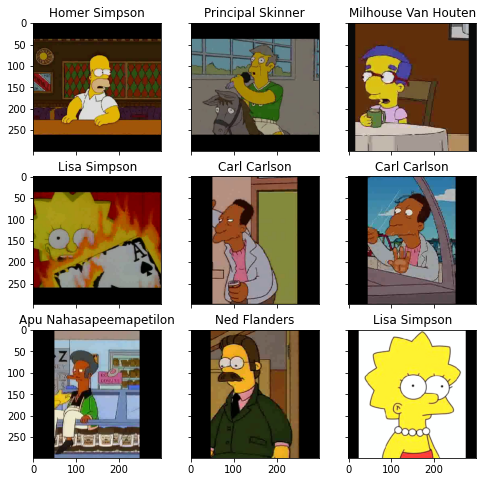

In [14]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,15000))
    im_train, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_train.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [15]:
train_loader_unshuffled = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=2, worker_init_fn=seed_worker)

In [16]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, worker_init_fn=seed_worker)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, worker_init_fn=seed_worker)

In [17]:
!pip install -q catalyst
from catalyst import utils
from sklearn.metrics import f1_score

     |████████████████████████████████| 491kB 8.5MB/s 
     |████████████████████████████████| 645kB 17.1MB/s 
     |████████████████████████████████| 122kB 13.3MB/s 
ERROR: bokeh 2.3.1 has requirement pillow>=7.1.0, but you'll have pillow 5.3.0 which is incompatible.


In [18]:
def train(train_loader, val_loader, model, num_epochs, optimizer, criterion, scheduler=None):

    best_model_wts = model.state_dict()
    best_epoch = 0
    best_score = 0
    losses = {'train': [], "val": []}

    pbar = trange(num_epochs, desc="Epoch:")

    loaders = {"train": train_loader, "val": val_loader}

    for epoch in pbar:

        for k, dataloader in loaders.items():

            running_loss = 0.0
            epoch_preds, epoch_batches = [], []

            for batch in  tqdm(dataloader, leave=False, desc=f"{k} iter:"):
                x_batch, y_batch = batch
                x_batch = x_batch.to(DEVICE)
                y_batch = y_batch.to(DEVICE)
                if k == "train":
                    model.train()  
                    optimizer.zero_grad() 
                    outp, aux = model(x_batch)
                    loss1 = criterion(outp, y_batch)
                    loss2 = criterion(aux, y_batch)
                    loss = loss1 + 0.4 * loss2
                    loss.backward()  
                    optimizer.step()  
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)
                        loss = criterion(outp, y_batch)

                preds = outp.argmax(-1)

                epoch_preds += preds.cpu()
                epoch_batches += y_batch.cpu()
                running_loss += loss.item() * x_batch.size(0)

            epoch_score = f1_score(epoch_preds, epoch_batches, average='micro')
            epoch_loss = running_loss / len(dataloader.dataset)
            losses[k].append(epoch_loss)

            if k == 'val': 
              print(f'Epoch: {epoch + 1} of {num_epochs}  Score: {epoch_score}')
              if scheduler is not None:
                scheduler.step(epoch_loss)
            
            pbar.set_description('{} Loss: {:.4f} Score: {:.4f}'.format(k, epoch_loss, epoch_score))

            if k == 'val' and epoch_score > best_score:
              best_score = epoch_score
              best_epoch = epoch + 1
              best_model_wts = model.state_dict()

    print(f'Best score: {best_score}\nEpoch {best_epoch} of {num_epochs}')
    model.load_state_dict(best_model_wts)
    return model, losses, best_score

In [19]:
def predict(model, loader, batch_size):
    model.eval()
    with torch.no_grad():
        logits = []
    
        for inputs in loader:
            inputs = inputs.to(DEVICE)
            outp = model(inputs).cpu()
            logits.append(outp)
            
    preds = torch.cat(logits).numpy()

    return preds

In [20]:
def class_score(model, loader):

    label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
    keys = label_encoder.classes_
    classes_predict = {key: [] for key in keys}
    classes_correct = {key: [] for key in keys}

    model.eval()
    with torch.no_grad():
        for batch in tqdm(loader, leave=False):
            inputs, labels = batch
            inputs = inputs.to(DEVICE)
            outp = model(inputs).cpu()
            preds = outp.argmax(-1)
            for pred, label in zip(preds, labels):
                key = label_encoder.inverse_transform([label]).item()
                classes_predict[key].append(pred)
                classes_correct[key].append(label)

    data = []
    for key in keys:
        data.append((key, len(classes_correct[key]), round(f1_score(classes_predict[key], classes_correct[key], average='micro'), ndigits=5)))

    return pd.DataFrame(columns=['Class', 'N', 'F1-score'], data=data).sort_values(by='F1-score')

In [21]:
import seaborn as sns

def plot_loss(losses):
  sns.set(style="whitegrid", font_scale=1.4)
  plt.figure(figsize=(12, 8))
  plt.plot(losses['train'], label="train")
  plt.plot(losses['val'], label="val")
  plt.legend()
  plt.show()

В качестве модели выберем Incepton V3. Для начала обучим 2 эпохи и посмотрим на изображения из трейна, которые сеть не смогла верно распознать.

In [22]:
torch.cuda.empty_cache()

In [23]:
inception_v3 = models.inception_v3(pretrained=True)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


In [ ]:
inception_v3

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [24]:
inception_v3.fc = nn.Linear(2048, 42)
inception_v3.AuxLogits.fc = nn.Linear(768, 42)

In [25]:
inception_v3 = inception_v3.to(DEVICE)

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(inception_v3.parameters(), lr=1e-4)

inception_v3, losses_inception_v3, f1_inception_v3 = train(train_loader, val_loader, model=inception_v3, num_epochs=2, optimizer=optimizer, criterion=criterion)

Epoch: 1 of 2  Score: 0.9421092854413451


Epoch: 2 of 2  Score: 0.9572029040886512

Best score: 0.9572029040886512
Epoch 2 of 2


In [ ]:
torch.save(inception_v3.state_dict(), '/content/gdrive/MyDrive/JourneySpringfield/inception_v3_imb.pth')

In [ ]:
#inception_v3.load_state_dict(torch.load('/content/gdrive/MyDrive/JourneySpringfield/inception_v3_imb.pth'))

In [27]:
def incorrect_samples(model, loader):
    incorrects, paths = [], []
    cnt = 0
    model.eval()
    with torch.no_grad():
        for batch in tqdm(loader, leave=False):
          x, y = batch
          for image, label in zip(x, y):
            image = image.unsqueeze(0).to(DEVICE)
            outp = model(image).cpu()
            pred = outp.argmax(-1)
            if pred != label:
              incorrects.append((image.cpu(), label, pred))
              paths.append(loader.dataset.files[cnt])
            cnt += 1

    return paths, incorrects

In [28]:
incorrect_paths, incorrect_images = incorrect_samples(inception_v3, train_loader_unshuffled)

In [29]:
len(incorrect_images)

324

In [30]:
incorrect_images_1 = incorrect_images[:162]
incorrect_images_2 = incorrect_images[162:]

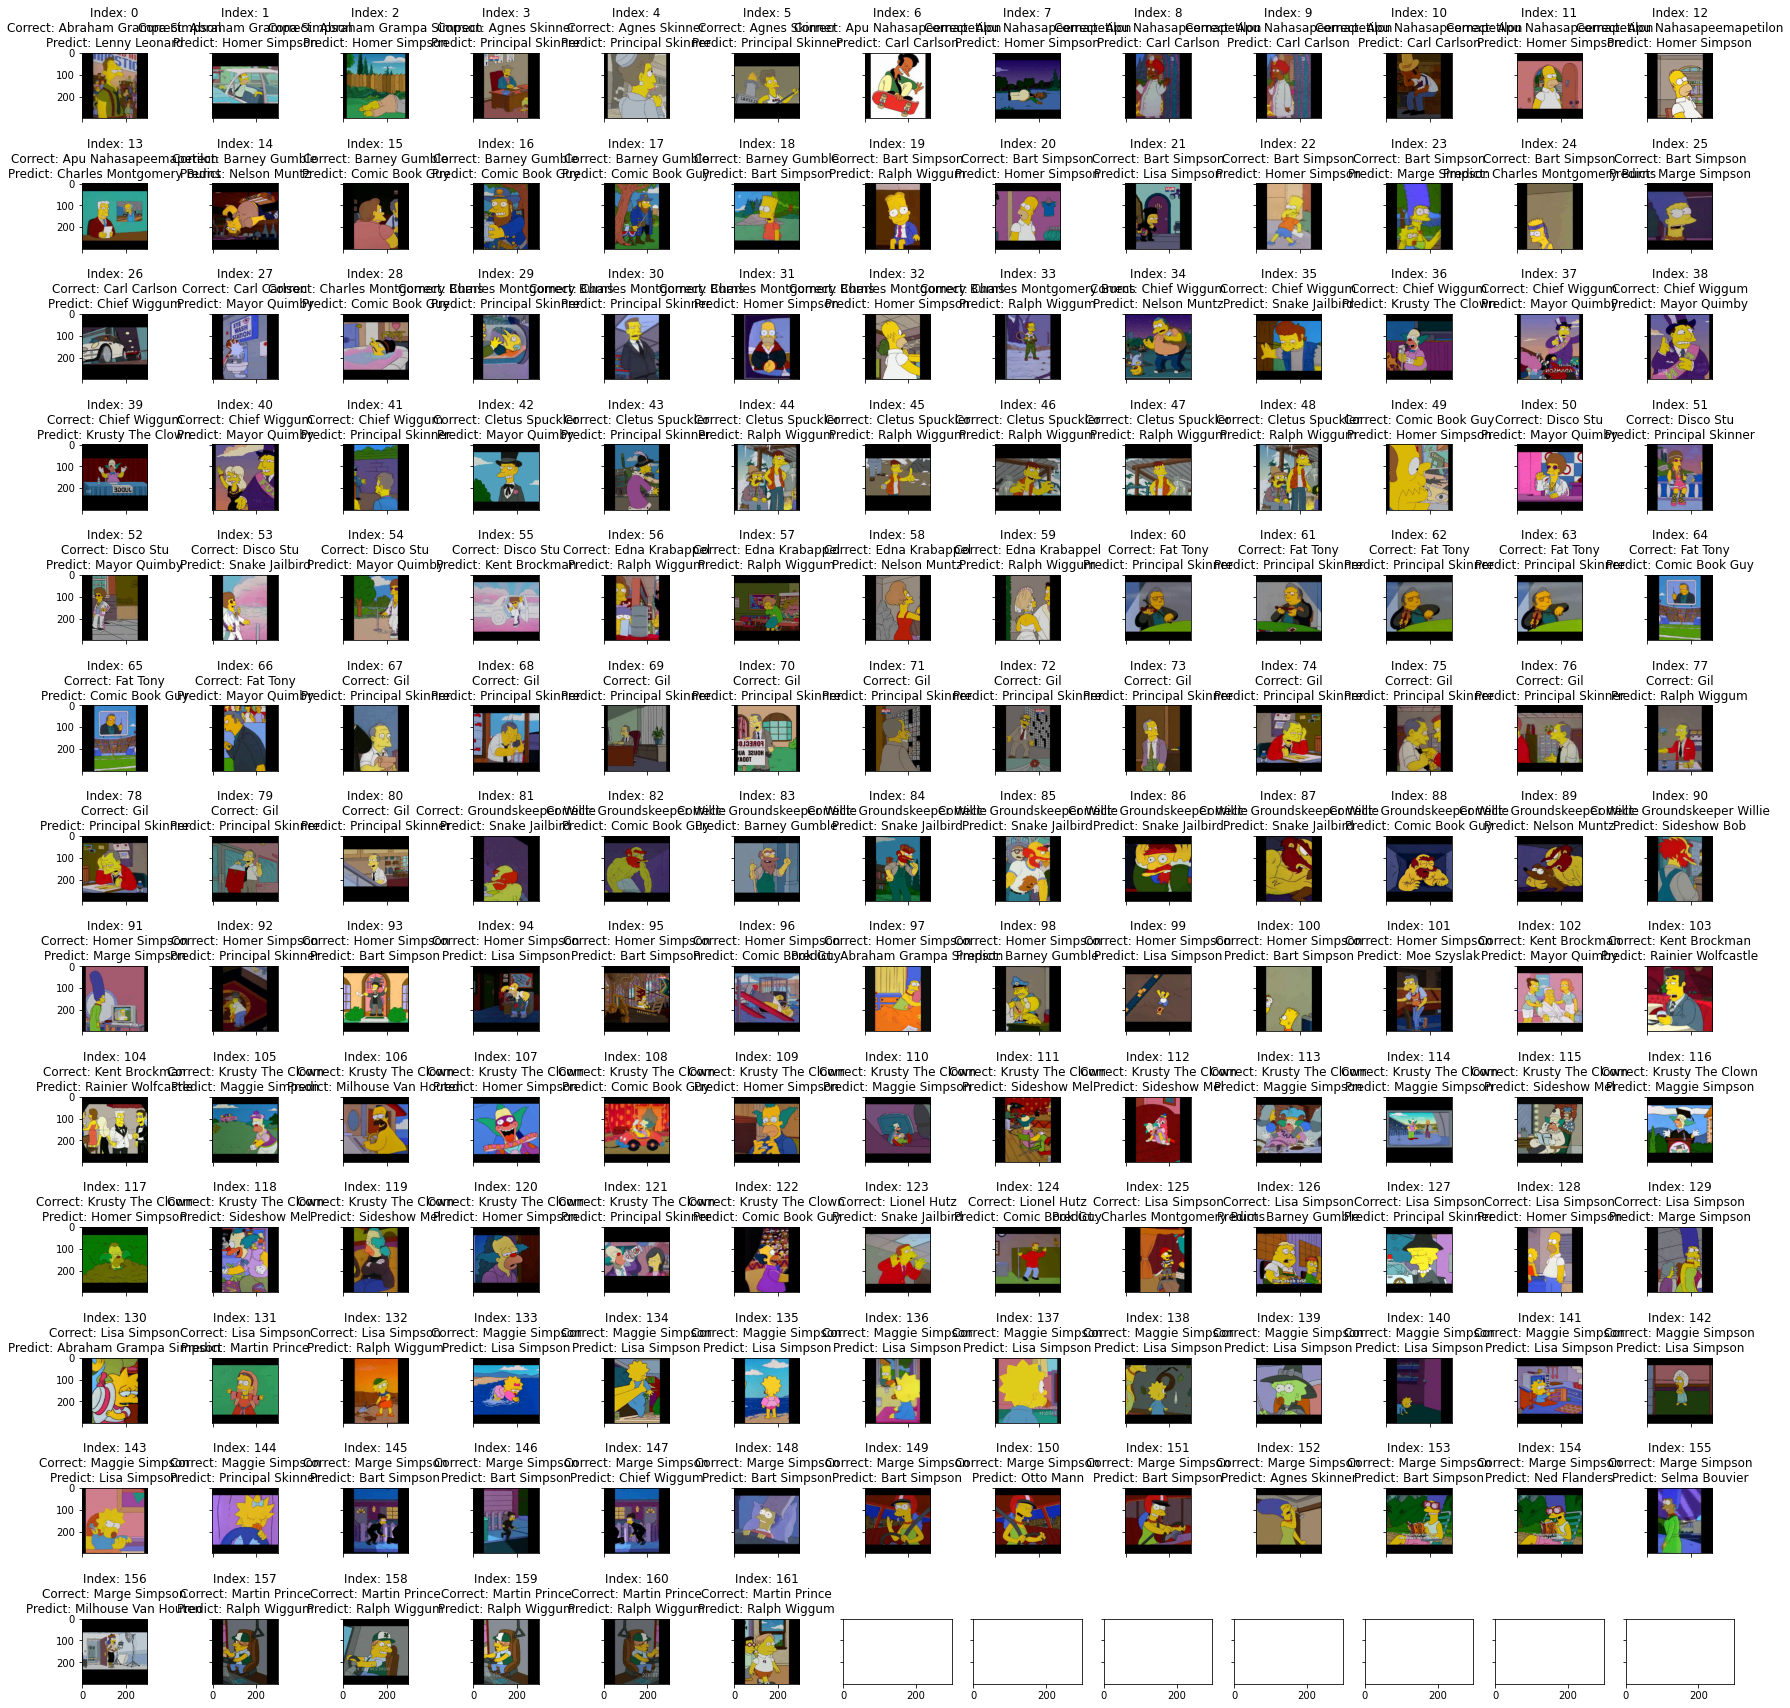

In [ ]:
fig, ax = plt.subplots(nrows=13, ncols=13,figsize=(30, 30), \
                        sharey=True, sharex=True)
plt.subplots_adjust(hspace=1)
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
for i, (fig_x, sample) in enumerate(zip(ax.flatten(), incorrect_images_1)):
    img, label, pred = sample
    label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    pred = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([pred])[0].split('_')))
    imshow(img.squeeze(0), \
          title=f'Index: {i}\nCorrect: {label}\nPredict: {pred}' ,plt_ax=fig_x)

In [31]:
train_files.remove(incorrect_paths[3])
train_files.remove(incorrect_paths[11])
train_files.remove(incorrect_paths[12])
train_files.remove(incorrect_paths[18])
train_files.remove(incorrect_paths[20])
train_files.remove(incorrect_paths[23])
train_files.remove(incorrect_paths[25])
train_files.remove(incorrect_paths[30])
train_files.remove(incorrect_paths[31])
train_files.remove(incorrect_paths[32])
train_files.remove(incorrect_paths[35])
train_files.remove(incorrect_paths[36])
train_files.remove(incorrect_paths[37])
train_files.remove(incorrect_paths[38])
train_files.remove(incorrect_paths[39])
train_files.remove(incorrect_paths[40])
train_files.remove(incorrect_paths[41])
train_files.remove(incorrect_paths[91])
train_files.remove(incorrect_paths[97])
train_files.remove(incorrect_paths[98])
train_files.remove(incorrect_paths[100])
train_files.remove(incorrect_paths[101])
train_files.remove(incorrect_paths[126])
train_files.remove(incorrect_paths[128])
train_files.remove(incorrect_paths[129])

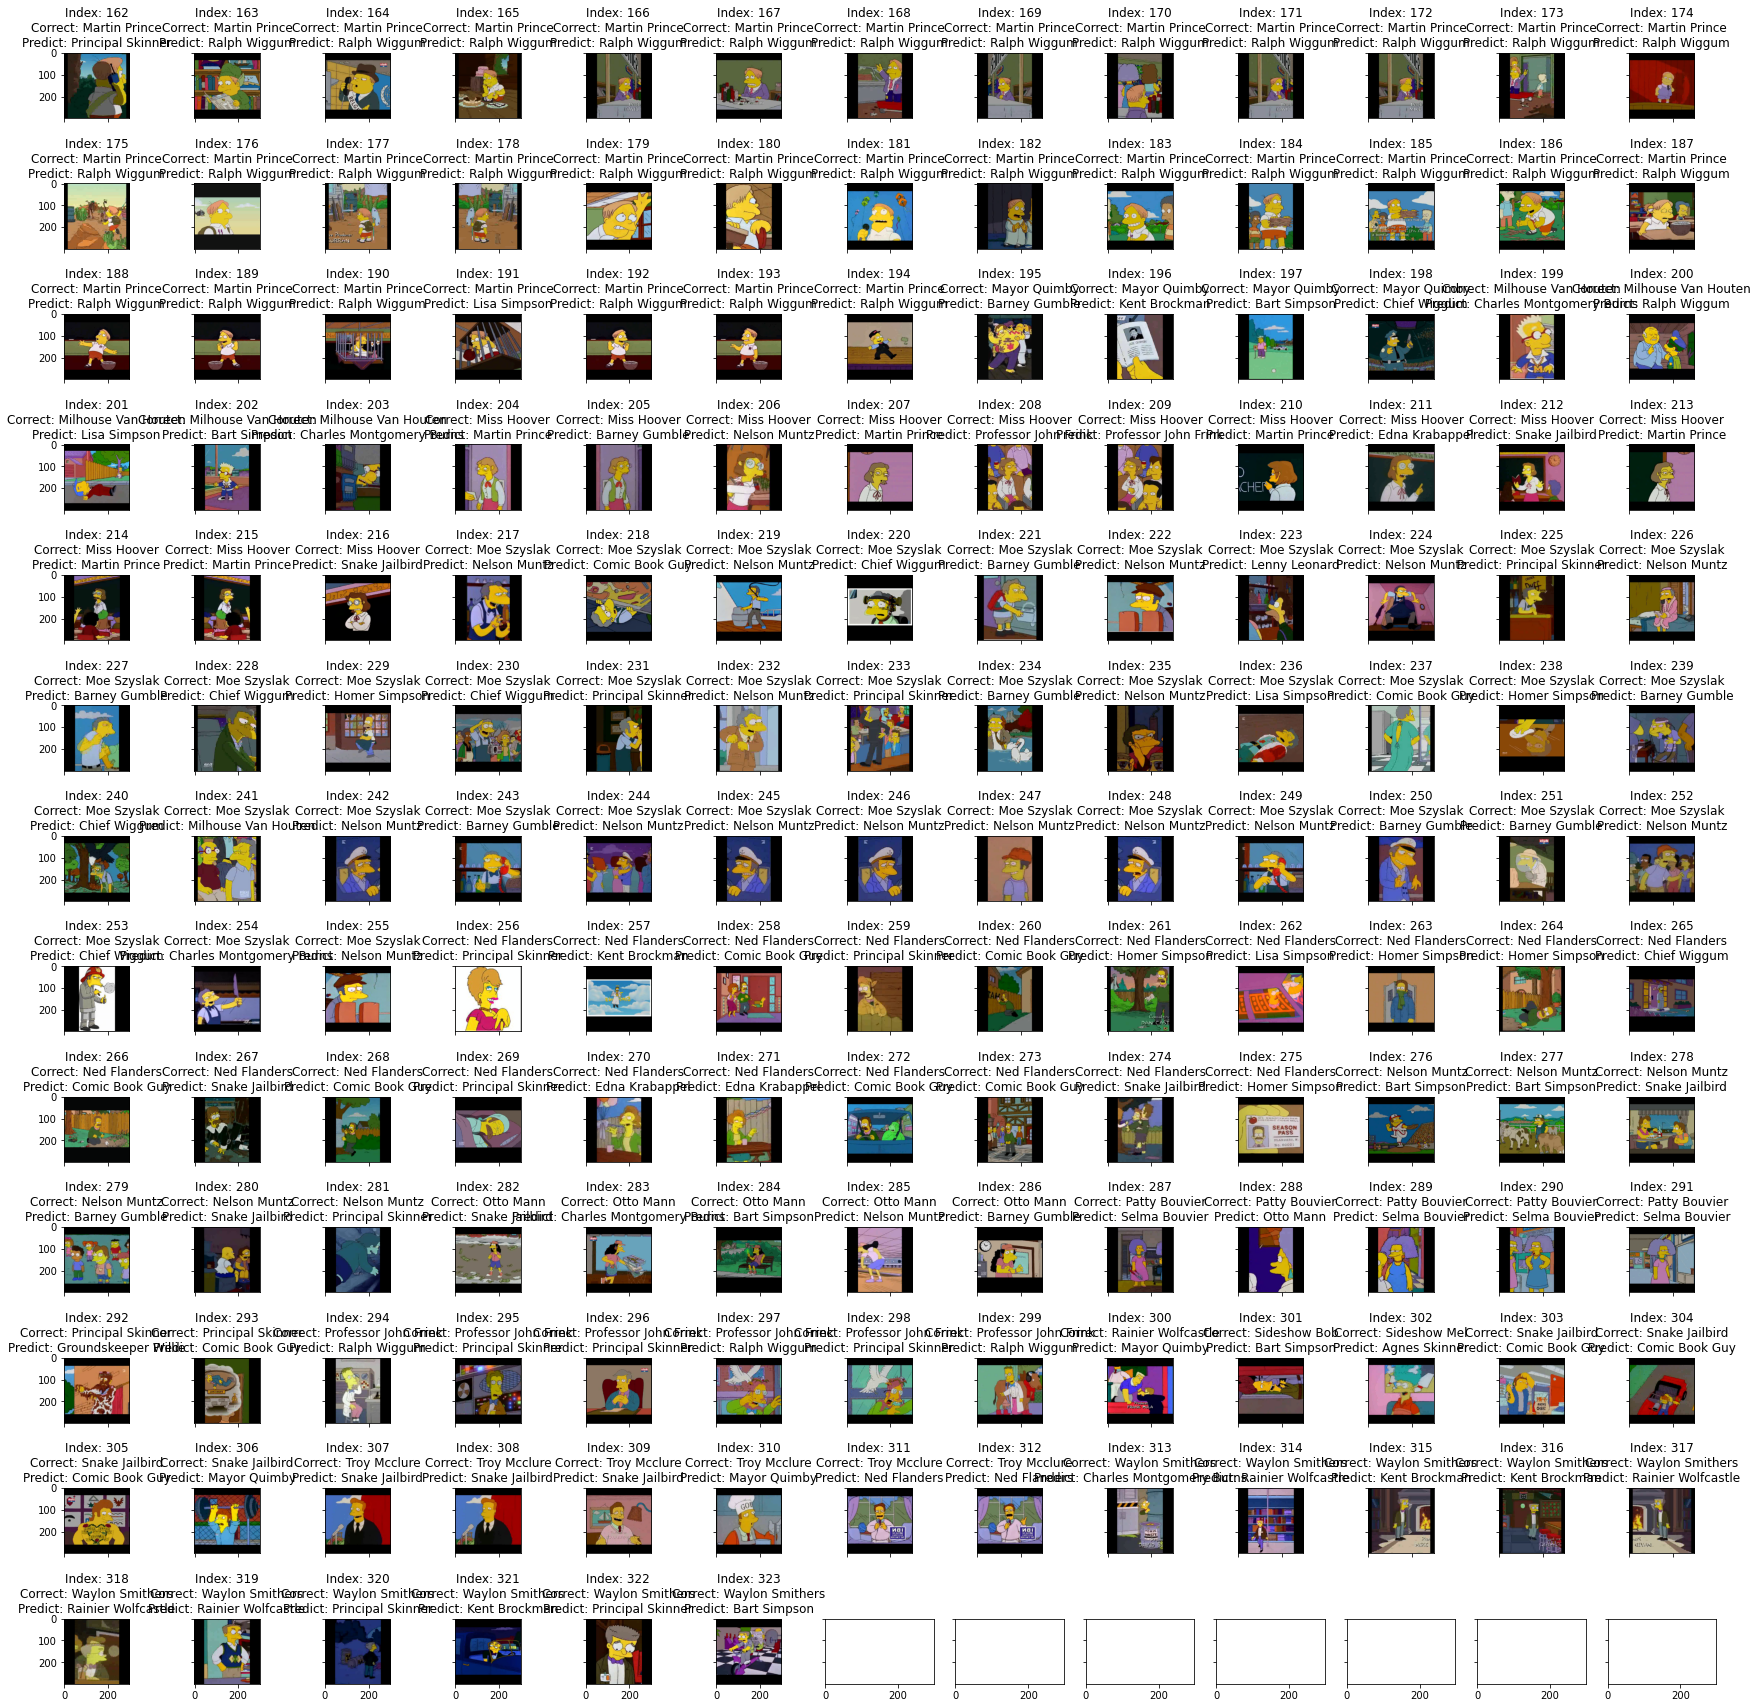

In [ ]:
fig, ax = plt.subplots(nrows=13, ncols=13,figsize=(30, 30), \
                        sharey=True, sharex=True)
plt.subplots_adjust(hspace=1)
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
for i, (fig_x, sample) in enumerate(zip(ax.flatten(), incorrect_images_2)):
    img, label, pred = sample
    label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    pred = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([pred])[0].split('_')))
    imshow(img.squeeze(0), \
          title=f'Index: {i + 162}\nCorrect: {label}\nPredict: {pred}' ,plt_ax=fig_x)

In [32]:
train_files.remove(incorrect_paths[198])
train_files.remove(incorrect_paths[229])
train_files.remove(incorrect_paths[256])
train_files.remove(incorrect_paths[270])
train_files.remove(incorrect_paths[271])
train_files.remove(incorrect_paths[296])

Как можно увидеть, в трейн части есть ошибки. Кроме того, имеются изображения, на которых изображены более одного персонажа, из-за чего нельзя однозначно классифицировать изображение. Удалим подобные примеры.

In [33]:
len(train_files)

15668

In [34]:
train_dataset_fixed = SimpsonsDataset(train_files, mode='train', augment=True)

Посмотрим, сколько изображений каждого класса находятся в трейне.

In [35]:
def class_counter(loader, classes):
  cnt = {key: 0 for key in range(len(classes))}
  for _, labels in tqdm(loader):
    for label in labels:
      cnt[label.item()] += 1
  return cnt

In [36]:
train_loader_imbalanced = DataLoader(train_dataset_fixed, batch_size=32, num_workers=2, worker_init_fn=seed_worker)

In [37]:
class_cnt_imbalanced = class_counter(train_loader_imbalanced, np.unique(train_val_labels))
pd.DataFrame(columns=['Label', 'N'], data=class_cnt_imbalanced.items()).sort_values(by='N')

,Label,N
19,19,2
10,10,6
40,40,6
26,26,13
12,12,20
13,13,20
30,30,24
38,38,30
1,1,31
34,34,34


Видим сильный дисбаланс классов. Сбалансируем датасет с помощью класса ImbalancedDatasetSampler (https://github.com/ufoym/imbalanced-dataset-sampler/blob/master/torchsampler/imbalanced.py).

In [38]:
class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):

    def __init__(self, dataset, label_to_count, indices: list = None, num_samples: int = None):

        generator = torch.Generator()
        self.generator = generator.manual_seed(42)
        
        self.indices = list(range(len(dataset))) if indices is None else indices
        
        self.num_samples = len(self.indices) if num_samples is None else num_samples
        
        weights = [1.0 / label_to_count[dataset[idx][1]] for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(self.weights, self.num_samples, replacement=True, generator=self.generator))

    def __len__(self):
        return self.num_samples

In [39]:
sampler = ImbalancedDatasetSampler(train_dataset_fixed, class_cnt_imbalanced)

train_loader_balanced = DataLoader(train_dataset_fixed, batch_size=32, sampler=sampler, num_workers=2, worker_init_fn=seed_worker)

In [ ]:
class_cnt_balanced = class_counter(train_loader_balanced, np.unique(train_val_labels))
pd.DataFrame(columns=['Label', 'N'], data=class_cnt_balanced.items()).sort_values(by='N')

,Label,N
19,19,328
3,3,339
37,37,347
36,36,352
14,14,352
21,21,358
22,22,359
6,6,360
0,0,363
9,9,364


После балансировки классов продолжим обучение модели. Уменьшим lr и добавим scheduller.

In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(inception_v3.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=2, verbose=True)

inception_v3, losses_inception_v3, f1_inception_v3 = train(train_loader_balanced, val_loader, model=inception_v3, num_epochs=10, optimizer=optimizer, criterion=criterion, scheduler=scheduler)

Epoch: 1 of 10  Score: 0.976881925869316


Epoch: 2 of 10  Score: 0.9782193351165457


Epoch: 3 of 10  Score: 0.9795567443637753


Epoch: 4 of 10  Score: 0.9797478028276653


Epoch: 5 of 10  Score: 0.9795567443637753


Epoch: 6 of 10  Score: 0.9791746274359954


Epoch: 7 of 10  Score: 0.9799388612915552


Epoch: 8 of 10  Score: 0.9793656858998854
Epoch     8: reducing learning rate of group 0 to 1.0000e-06.


Epoch: 9 of 10  Score: 0.9805120366832251


Epoch: 10 of 10  Score: 0.9801299197554452

Best score: 0.9805120366832251
Epoch 9 of 10


In [45]:
torch.save(inception_v3.state_dict(), '/content/gdrive/MyDrive/JourneySpringfield/inception_v3_bal.pth')

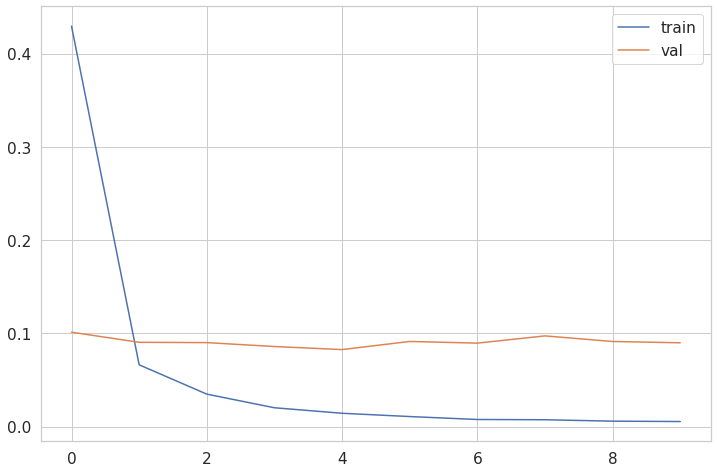

In [41]:
plot_loss(losses_inception_v3)

Посмотрим, какие классы наша сеть не смогла распознать. Видно, что проблему с малочисленными классами частично удалось решить.

In [42]:
cls_scores_inception_v3 = class_score(inception_v3, val_loader)
cls_scores_inception_v3

,Class,N,F1-score
19,lionel_hutz,1,0.00000
26,miss_hoover,4,0.50000
12,fat_tony,7,0.71429
23,martin_prince,18,0.77778
1,agnes_skinner,10,0.80000
8,cletus_spuckler,12,0.83333
21,maggie_simpson,32,0.87500
30,otto_mann,8,0.87500
33,professor_john_frink,16,0.87500
38,sideshow_mel,10,0.90000


In [43]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=32, worker_init_fn=seed_worker)

probs = predict(inception_v3, test_loader, batch_size=32)
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

my_submit = pd.read_csv("sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [44]:
my_submit.to_csv('inception_v3_baseline.csv', index=False)